# Sažetak 

Računalno modeliranje kretanja rakete odnosno računska simulacija trajektorije rakete se na osnovnoj razini može tretirati kao prigušeno njihalo. Na oboje utječu tri sile: gravitacijska sila, sila otpora zraka i pokretačke sile. Ako govorimo o kretanju rakete, ove sile su opisane masom rakete, atmosferskim otporom, otporom valova i potisne sile uzrokovane izgaranjem goriva. Vidjet ćemo kako nije trivijalno modelirati trajektoriju rakete te ćemo uvesti mnoge pretpostavke i pojednostavljenja kako bismo donekle uspjeli modelirati kretanje rakete.


# Uvod s istraživanjem područja


Računalno modeliranje kretanja rakete zahtjevan je postupak koji iziskuje izrazito dobra predznanja iz područja fizike, matematike i programiranja. Potrebno je dobro razumjeti sve sile koje djeluju na raketu i kako se mijenjaju kroz vrijeme, potrebno je ispravno matematički opisati te promijene, te je potrebno napisati efikasan i brz kod koji će pouzdano izračunati trajektoriju kretanja rakete. Svaka, pa i najmanja pogreška može imati katastrofalne posljedice, kako novčane tako i ljudske.

Yuri Gagarin je 1961. godine, u raketi "Vostok 1", bio prvi čovjek u svemiru, a samo 8 godina kasnije, 1969., u sklopu 'Apollo' programa, prvi ljudi su sletjeli na Mjesec. No, unatoč velikim uspjesima u istraživanju svemira, 1986. godine se dogodila tragična nesreća u kojoj je raketa "Challenger", koja je nosila posadu od sedmero ljudi, eksplodirala. Iz ovoga možemo zaključiti da je moguće dovoljno dobro simulirati trajektoriju rakete, no teško je modelirati stvarni svijet te kako će se raketa točno ponašati u stvarnim uvjetima.


# Teorijska podloga rješenja i implementacija u python kod.
    

Jednadžbu kretanja rakete možemo opisati formulom:

$\vec{F_{net}} = \vec{F_{pogon}} - \vec{F_{otpor}} - \vec{F_{G}}$

Opišimo malo detaljnije svaku od ovih sila.

### Potisna sila (pogon) $\vec{F_{pogon}}$

S obzirom na to da je većini raketa za pogon potrebno tekuće gorivo, moguće je kontrolirati potisnu silu u ovisnosti o trenutnoj visini na kojoj se raketa nalazi. Na taj način ćemo vjerojatno postići optimalnu potrošnju goriva i time bolje performanse.

No, kako bismo pojednostavili račun, pretpostavit ćemo da je potisna sila konstantna. Sada možemo matematički opisati potisnu silu kako slijedi:

$\vec{F_{pogon}} = \begin{cases} konstantna, &  t\lt t_{izgaranja} \\ 0 , & inače \end{cases}$

Možemo vidjeti da će raketa imati konstantnu potisnu silu sve do trenutka dok joj ne ponestane goriva. U tom trenutku će iznos potisne sile postati 0. Iz ovoga zaključujemo da potisna sila ovisi samo o proteklom vremenu.

### Atmosferski otpor $\vec{F_{otpor}}$

Atmosferski otpor je vrsta parazitskog otpora (otpor koji nastaje prilikom kretanja tijela kroz fluid), koji nastaje zbog sudaranja molekula zraka s površinom rakete. Formula koja opisuje atmosferski otpor dana je formulom:

$\vec{F_{otpor}} = \frac{1}{2} \cdot \rho(z) \cdot v^2 \cdot C_D \cdot A$

gdje je $\rho$ gustoća zraka, $v$ brzina rakete, $C_D$ koeficijent trenja, $A$ presjek rakete.

Gustoću zraka računamo prema izrazima:

$p(z)=\frac{M \cdot T(z)}{R \cdot P(z)}$

$T(z) = T_0 - L_z$

$P(z) = P_0 \cdot (\frac{T_0}{T_0-L_z})^\frac{g_0 \cdot M}{R \cdot L}$

### Otpor valova

Otpor valova nastaje zbog kompresije valova zraka te ćemo njega također morati uračunati pod sveukupni otpor. Taj otpor najviše dolazi do izražaja prije probijanja zvučnog zida što ćemo vidjeti u našoj simulaciji.

### Gravitacijska sila $\vec{F_{G}}$

Silu gravitacije predstavljamo sa dobro poznatom formulom: 

$F_G=m \cdot g$, gdje za klasične probleme koristimo $g=9.81 m/s^2$

U slučaju rakete morat ćemo koristiti malo kompliciraniju verziju ove formule jer će se i gravitacijska akceleracija i masa rakete mijenjati u ovisnosti o vremenu i visini od površine zemlje:

$F_G=m(t) \cdot g(z)$

gdje se funkcija gravitacijske akceleracije u ovisnosti o visini računa prema izrazu:

$g(z) = \frac{G \cdot M_E}{(z+R_E)^2}$, gdje je $G$ gravitacijska konstanta, $M_E$ masa zemlje, $R_E$ radius zemlje i $z$ visina od površine zemlje

, a funkcija mase u ovisnosti u vremenu:

$m(t) = m_0 - \dot{m}t$, gdje je $m_0$ početna masa, $t$ vrijeme, $\dot{m}$ stopa promjene mase 

stopu promjene mase $\dot{m}$ možemo izračunati prema Tsiolkovsky jednadžbi za rakete:

$\dot{m} = \frac{F_{pogon}}{g_0I_{sp}}$, gdje je $I_{sp}$ efikasnost motora koja je uglavnom poznata za rakete.

### Pomoćne biblioteke

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### Inicijalizacija univerzalnih konstanti (G, M_earth, mol, R, P0, T0, rho0, g0)

In [2]:
G = 6.67430e-11  # Newtonian constant of gravitation
g0 = 9.80665  # standard acceleration of gravity
M_earth = 5.972e24  # earth mass (kg)
R_earth = 6371000  # earth radius (m)
mol = 0.029  # molar mass of air
rho_0 = 1.225  # air density
R = 8.314  # gas constant
P0 = 101325  # standard pressure (Pa), sea level
T0 = 303  # temperature (K), sea level

In [3]:
rho0 = (mol*P0)/(R*T0)  # air density, sea level
rho0

1.1664388113095652

 ### Inicijalizacija specifikacija rakete (pogon, koef. trenja, promjer, površina, masa rakete s gorivom i bez, efikasnost motora, stopa promijene mase)

In [4]:
FT = 560000  # rocket thrust, in Newtons
C0 = 0.75  # drag coefficient, see notes
d = 1.7  # rocket diameter, in meters
A = math.pi*(d/2) ** 2  # rocket cross-sectional area
L = 27.4  # rocket length, in meters
m0 = 46760  # initial mass, in kg ("wet mass")
empty = 3120  # mass when fuel is expended, in kg ("dry mass")
Isp = 221  # specific impulse, in seconds
dm = FT/(g0*Isp)  # mass flow rate, dm/dt

### Inicijalizacija visine (1 m), brzine (0 m/s), mase (m0), gustoće zraka (rho0) i gravitacije (g0)

In [5]:
dt = 0.1  # time step
z0 = 1  # intial altitude
v0 = 0  # initial velocity
v = v0
z = z0
V = [v]
Z = [z]
m = m0
Rho=[rho0]
T=[T0]
P=[P0]
M = [m]
Thrust = [FT/m]
Drag = [0]
g=g0
grav=[g]
nextstage=0
tmax = 500

### Pomoćne funkcije

In [6]:
def density(_z): 
    '''
    promijena gustoće zraka ovisna o visini _z
    '''
    _mol = 0.029
    _R = 8.314
    _h = _z/1000  # _h, altitude in km
    if _h <= 11:  # pressure and temperature values by altitude
        _T = 288.15 - 6.5*_h
        _P = 101325*((288.15/(288.15-6.5*_h))**(34.1632/-6.5))
    elif 11 < _h and _h <= 20:
        _T = 216.65
        _P = 22632.06*math.exp(-34.1632*(_h-11)/216.65)
    elif 20 < _h and _h <= 32:
        _T = 196.65 + 0.001*_z
        _P = 5474.889 * ((216.65/(216.65+(_h-20)))**(34.1632))
    elif 32 < _h and _h <= 47:
        _T = 139.05 + 2.8*_h
        _P = 868.0187 * ((228.65/(228.65+2.8*(_h-32)))**(34.1632/2.8))
    elif 47 < _h and _h <= 51:
        _T = 270.65
        _P = 110.9063 * math.exp(-34.1632*(_h-47)/270.65)
    elif 51 < _h and _h <= 71:
        _T = 413.45 - 2.8*_h
        _P = 66.93887*((270.65/(270.65-2.8*(_h-51)))**(34.1632/-2.8))
    else: #71 < _h and _h <= 86
        _T = 356.65 - 2.0*_h
        _P = 3.956420*((214.65/(214.65-2*(_h-71)))**(34.1632/-2))
    
    _rho = (_mol*_P)/(_R*_T)
    if 86 < _h and _h <= 91:
        _P = math.exp(-4.22012E-08*_h**5 + 2.13489E-05*_h**4 - 4.26388E-03*_h**3 + 0.421404*_h**2 - 20.8270*_h + 416.225)
        _rho = math.exp(7.5691E-08*_h**5 - 3.76113E-05*_h**4 + 0.0074765*_h**3 - 0.743012*_h**2 + 36.7280*_h - 729.346 )
        _T = 186.8673
    elif 91 < _h and _h <= 100:
        _P = math.exp(-4.22012E-08*_h**5 + 2.13489E-05*_h**4 - 4.26388E-03*_h**3 + 0.421404*_h**2 - 20.8270*_h + 416.225)
        _rho = math.exp(7.5691E-08*_h**5 - 3.76113E-05*_h**4 + 0.0074765*_h**3 - 0.743012*_h**2 + 36.7280*_h - 729.346 )
        _T = 263.1905-76.3232*math.sqrt(1 - ((_h-91)/-19.9429)**2)
    elif 100 < _h and _h <= 110:
        _P = math.exp(-4.22012E-08*_h**5 + 2.13489E-05*_h**4 - 4.26388E-03*_h**3 +0.421404*_h**2 - 20.8270*_h + 416.225)
        _rho = math.exp(7.5691E-08*_h**5 - 3.76113E-05*_h**4 + 0.0074765*_h**3 - .743012*_h**2 + 36.7280*_h - 729.346 )
        _T = 263.1905-76.3232*math.sqrt(1 - ((_h-91)/-19.9429)**2)
    elif 110 < _h and _h <= 120:
        _rho = math.exp(-8.854164E-05*_h**3 + 0.03373254*_h**2 - 4.390837*_h +176.5294)
        _P = 0
        _T = 240 + 12*(_h-110)
    elif 120 < _h and _h <= 150:
        _P = 0
        _rho = math.exp(3.661771E-07*_h**4 - 2.154344E-04*_h**3 + 0.04809214*_h**2 -4.884744*_h + 172.3597)
        _T = 1000 - 640*math.exp(-0.01875*(_h-120)*(6356.766 + 120)/(6356.766+_h))
    elif 150 < _h: #and _h <= 200
        _P = 0
        _rho = 02.0763e-09
        _T = 1000 - 640*math.exp(-0.01875*(_h-120)*(6356.766 + 120)/(6356.766+_h))
    
    return _rho, _T, _P

def CD(_v, _T, _C0):
    '''
    Funkcija za izračunavanje koeficijenta otpora
    '''
    cs = math.sqrt(1.4*287*_T)  # sound speed as function of temperature
    Mach = _v/cs  # Mach number
    if Mach < 1:
        _Cd = _C0/math.sqrt(1-Mach**2)  # Prandtl-Glauert Rule
    elif Mach == 1:
        Mach = 0.99999  # eliminate the singularity
        _Cd = _C0/math.sqrt(1-Mach**2)
    elif Mach > 1:
        _Cd = _C0/math.sqrt(Mach**2 - 1)
    
    return _Cd

### Euler-Cromer metoda

In [7]:
no_fuel = False
for t in np.arange(dt,tmax,dt):
#     print(f"t={t} G={G} M={M_earth} z={z}")
    g = (G*M_earth)/((z+R_earth) ** 2)  # gravitational acceleration, g(z)
    m = m - (dm*dt)  # changing mass, m(t)
    rho,temp,press = density(z) # changing air density by barometric formula, rho(z)
    Cd = CD(v,temp,C0)
    thrust = FT/m
    drag = 0.5*rho*(v**2)*Cd*A/m
    
    if v < 0:  # flip drag force vector if rocket falls
        drag = drag*-1
        
    v = v + (thrust - drag - g)*dt  # new velocity
    z = z + v*dt  # new altitude
    
    V.append(v)
    Z.append(z)
    M.append(m)
    grav.append(g)
    Thrust.append(thrust)
    Drag.append(drag)
    Rho.append(rho)
    T.append(temp)
    P.append(press)
    t1=t
    if z < 0:  # rocket crashes or fails to launch
        print("Rocket fail z=",z)
        break
    elif m < empty and not no_fuel:  # rocket runs out of fuel, mass becomes stable
        no_fuel = True
        FT = 0
        dm = 0
        print(f"Rocket out of fuel! Altitude={z} meters time={t}")


Rocket out of fuel! Altitude=119419.3079896698 meters time=168.9


# Rasprava rezultata 
    

Prikažimo rezultate:

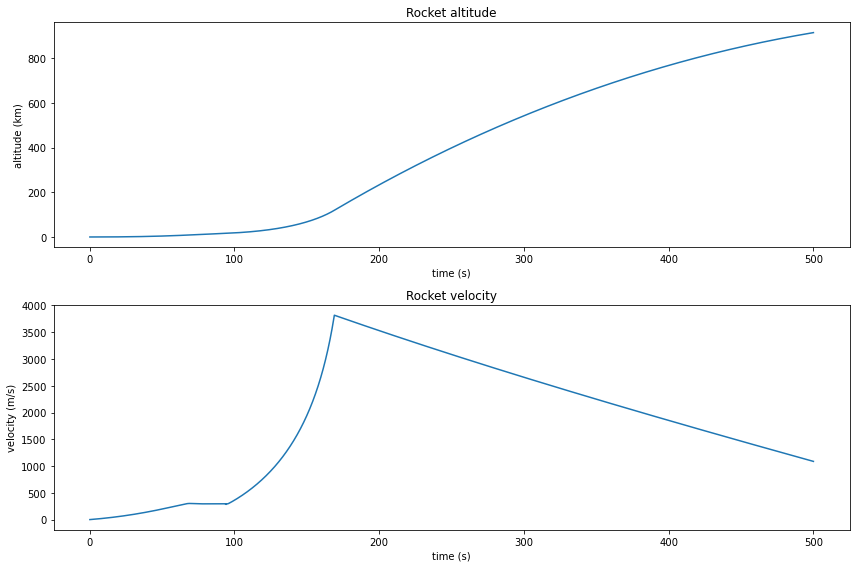

In [8]:
t = np.arange(dt,tmax+dt,dt)
Z = np.array(Z)

plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(t,Z/1000)
plt.title('Rocket altitude')
plt.xlabel('time (s)')
plt.ylabel('altitude (km)')

plt.subplot(2,1,2)
plt.plot(t,V)
plt.title('Rocket velocity')
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')

plt.tight_layout()


Iz prethodna dva grafa možemo vidjeti visinu i brzinu rakete u ovisnosti o vremenu. Na donjem grafu uočavamo usporavanje rakete nakon 169 sekundi od polijetanja. U tom trenutku raketa se nalazi na visini od 120 kilometara od zemljine površine te je ostala bez goriva što možemo vidjeti i na donjem grafu potisne sile. Unatoč linearnom usporavanju rakete, visina i dalje raste skoro pa linearno jer je raketa dovoljno udaljena od zemljine površine da se sve manje mora boriti sa zemljinom gravitacijskom silom.

Također, na krivulji brzine možemo uočiti neobično ponašanje između 65 i 95 sekundi nakon polijetanja. Naime, stagnacija u brzini u tom periodu se događa jer se raketa približava probijanju zvučnog zida. Tu do izražaja dolazi otpor valova, a to možemo primijetiti i na grafu otpora. Vidimo neobičan skok otpora nakon kojeg slijedi konstantna i niska razina otpora.

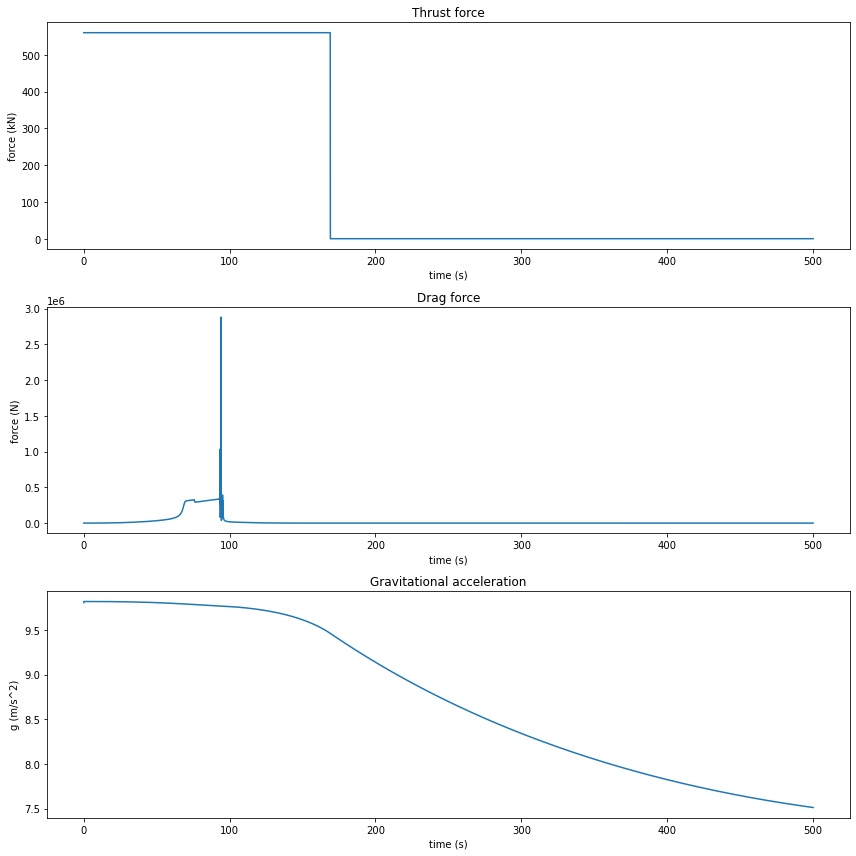

In [9]:
Thrust = np.array(Thrust)
M = np.array(M)

plt.figure(figsize=(12,12))

plt.subplot(3,1,1)
plt.plot(t,Thrust*(M/1000))
plt.title('Thrust force')
plt.xlabel('time (s)')
plt.ylabel('force (kN)')

plt.subplot(3,1,2)
plt.plot(t,Drag*M)
plt.title('Drag force')
plt.xlabel('time (s)')
plt.ylabel('force (N)')

plt.subplot(3,1,3)
plt.plot(t,grav)
plt.title('Gravitational acceleration')
plt.xlabel('time (s)')
plt.ylabel('g (m/s^2)')

plt.tight_layout()


Kao što smo vidjeli iz navedene simulacije, najveći dio posla se događa prije probijanja zvučnog zida, a upravo zbog toga što je otpor nakon probijanja zvučnog zida, na velikoj udaljenosti od zemljine površine, zanemariv. 

# Zaključak
    

Unatoč tome što su prve svemirske misije počele prije više od 60 godina i dalje je izrazito izazovno ispravno modelirati putanje svemirskih letjelica dijelom radi velikih udaljenosti koje moraju prijeći a dijelom radi mnogih nesigurnosti koje mogu nastupiti. Pri modeliranju ovakvih sustava izrazito je bitno paziti na detalje kako bi izbjegli novčane i vremenske troškove, a pogotovo kako bismo izbjegli ljudske gubitke.

U zadnje vrijeme se mnogo priča o komercijalnom putovanju na Mars. Neki stručnjaci su dovoljno optimistični da tvrde da bi se to moglo ostvariti u ovom desetljeću, no s obzirom na izrazitu kompleksnost postupka mnogi su skeptični.

# Literatura

- https://pages.vassar.edu/magnes/2019/05/12/computational-simulation-of-rocket-trajectories/
- https://physics.info/constants/
- https://physics.info/astronomical/
- https://www.nasa.gov/
- https://nssdc.gsfc.nasa.gov/
- https://skybrary.aero/articles/parasite-drag